## University of Wisconsin at Madison Examination of Grade Distributions 

The University of Wisconsin at Madison (UW-M) administration is concerned about enrollment, retention and graduation rates. As part of addressing this concern, was an examination of grades across all subjects over the 2006 - 2017. The goal was to understand four issues: 1. if STEM fields had different grade distributions than traditional liberal arts subjects, 2. Did large classes (more than 32 students, which is the 75th percentile of enrollment) had different grade distribution than smaller classes, 3. Does the time of day (before or after lunch) make a difference in grades, 4. Has there been a change in grade distributions over the 10 years of the dataset. The assumption is that grades are a proxy for student success and knowledge gained. UW-M publishes reports for all courses (and sections of these courses), instructors, subjects, and grade reports for each section for every Fall and Spring semester since 2006.

There are more than 9,000 courses in this dataset. There are nearly 200,000 course sections with grades, with 3 million grades reported in total. 18,000 instructors are included in the dataset, all of whom are associated with various sections that may or may not have grades reported for them.

The data was retrieved from the UW Madison registrar office, and extracted from PDF files using the open source tool, madgrades-extractor. This information was publicaly available on kaggle.

### Load the data and needed libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
from scipy.stats import ttest_ind
import scipy.stats as stats

In [14]:
conn = sqlite3.connect('uw-madison-courses/database.sqlite3')

In [3]:
c = conn.cursor()
c.execute("""SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE "sqlite%";""").fetchall()


[('sections',),
 ('instructors',),
 ('course_offerings',),
 ('subject_memberships',),
 ('courses',),
 ('rooms',),
 ('teachings',),
 ('subjects',),
 ('schedules',),
 ('grade_distributions',)]

In [325]:
c.execute('PRAGMA table_info(teachings)').fetchall()

[(0, 'instructor_id', 'TEXT', 0, None, 0),
 (1, 'section_uuid', 'TEXT', 0, None, 0)]

In [30]:
c.execute('PRAGMA table_info(course_offerings)').fetchall()

[(0, 'uuid', 'TEXT', 0, None, 0),
 (1, 'course_uuid', 'TEXT', 0, None, 0),
 (2, 'term_code', 'TEXT', 0, None, 0),
 (3, 'name', 'TEXT', 0, None, 0)]

In [45]:
df = pd.DataFrame(c.execute("""
select distinct name from course_offerings where name like "%101%" limit 20
;""").fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,name
0,Russ Honor Tutorial-Slav101


In [46]:
df = pd.DataFrame(c.execute("""
SELECT * FROM grade_distributions AS gd, course_offerings AS co,
sections s
WHERE co.uuid = gd.course_offering_uuid
AND s.course_offering_uuid = co.uuid

;""").fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,course_offering_uuid,section_number,n_count,c_count,f_count,cr_count,p_count,nw_count,other_count,bc_count,...,uuid,course_uuid,term_code,name,uuid,course_offering_uuid,section_type,number,room_uuid,schedule_uuid
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,0,0,0,0,0,0,0,0,...,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,Cooperative Education Prog,45adf63c-48c9-3659-8561-07556d2d4ddf,344b3ebe-da7e-314c-83ed-9425269695fd,FLD,1,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,0,0,0,0,0,0,0,0,...,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1082,Cooperative Education Prog,c6280e23-5e43-3859-893e-540d94993529,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,FLD,1,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,0,3,0,0,0,0,0,0,...,ea3b717c-d66b-30dc-8b37-964d9688295f,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1172,Cooperative Education Prog,9395dc21-15d1-3fab-8d1f-6f3fe6114c48,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,04368a56-c959-3e4b-8b3d-f4cc3538fea5,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
3,ea3b717c-d66b-30dc-8b37-964d9688295f,1,0,3,0,0,0,0,0,0,...,ea3b717c-d66b-30dc-8b37-964d9688295f,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1172,Cooperative Education Prog,b99e440b-39db-350a-81eb-b6eb1bd8b0bc,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
4,ea3b717c-d66b-30dc-8b37-964d9688295f,1,0,3,0,0,0,0,0,0,...,ea3b717c-d66b-30dc-8b37-964d9688295f,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1172,Cooperative Education Prog,ca1c841f-41d5-3298-bd25-01c65751f150,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90


In [33]:
df.columns

Index(['course_offering_uuid', 'section_number', 'n_count', 'c_count',
       'f_count', 'cr_count', 'p_count', 'nw_count', 'other_count', 'bc_count',
       'u_count', 'd_count', 'ab_count', 'a_count', 's_count', 'i_count',
       'b_count', 'nr_count', 'uuid', 'course_uuid', 'term_code', 'name',
       'uuid', 'course_offering_uuid', 'section_type', 'number', 'room_uuid',
       'schedule_uuid'],
      dtype='object')

### Exploratory Data Analysis of Question 2 - Do large classes have different grade distributions

In [47]:
#Class grade counts were saved as text, converted to numbers
df[['n_count', 'c_count', 'f_count', 'cr_count', 'p_count', 'nw_count', 'other_count', 'bc_count', 'u_count', 'd_count', 'ab_count', 'a_count', 's_count', 'i_count', 'b_count', 'nr_count']] = df[['n_count', 'c_count', 'f_count', 'cr_count', 'p_count', 'nw_count', 'other_count', 'bc_count','u_count', 'd_count', 'ab_count', 'a_count', 's_count', 'i_count',
       'b_count', 'nr_count']].astype(int)
    

In [48]:
#Create class enrollment feature, sum of all grade counts. Excluded all non-grade counts,
#(satisfactory, unsatisfactory, credit, no credit, progress, incomplete, and no report)
df['enrollment'] = df[['c_count', 'nw_count', 'f_count', 'bc_count', 'd_count', 'ab_count', 
                       'a_count', 'b_count']].sum(axis = 1)
df['enrollment'].head()

0    105
1    158
2    156
3    156
4    156
Name: enrollment, dtype: int64

In [49]:
#More than 100,000 or 52% classes have zero grades, which is the proxy for class enrollment. 
#The class with the most zero-grades is Research (13,074), and other research/thesis classes 
#are at the top. The bottom lists more unique classes like Thai Poetry that only have one or two empty classes.

df['enrollment'].value_counts().head()

0     1320124
19      42714
13      40997
18      39605
17      34846
Name: enrollment, dtype: int64

In [50]:
# Get rid of the empty classes without grades. Unrelated to our research
df = df[df["enrollment"] != 0]
df['enrollment'].value_counts().head()

19    42714
13    40997
18    39605
17    34846
12    33277
Name: enrollment, dtype: int64

In [51]:
# Calculate a total grade point for each class based on 
# registrar listing: https://registrar.wisc.edu/grades-and-gpa/
df['cum_grade'] = df['a_count'] * 4 + df['ab_count'] * 3.5 + df['b_count'] * 3.0 + df['bc_count'] * 2.5 \
+ df['c_count'] * 2.0 + df['d_count']


In [52]:
# create a GPA value for the class
df['class_gpa'] = df['cum_grade'] / df['enrollment']

In [53]:
# Calculate percentages for each grade

df["a_count_pct"] = df["a_count"]/df["enrollment"]
df["ab_count_pct"] = df["ab_count"]/df["enrollment"]
df["b_count_pct"] = df["b_count"]/df["enrollment"]
df["bc_count_pct"] = df["bc_count"]/df["enrollment"]
df["c_count_pct"] = df["c_count"]/df["enrollment"]
df["d_count_pct"] = df["d_count"]/df["enrollment"]
df["f_count_pct"] = df["f_count"]/df["enrollment"]
df["nw_count_pct"] = df["nw_count"]/df["enrollment"]

In [58]:
# Split up the data into separate sets
df_large_class = df[df['enrollment'] > 32]
df_medium_class = df[(df['enrollment'] <= 32) & (df['enrollment'] > 10)]
df_small_class = df[(df['enrollment'] <= 10) & (df['enrollment'] > 0)]

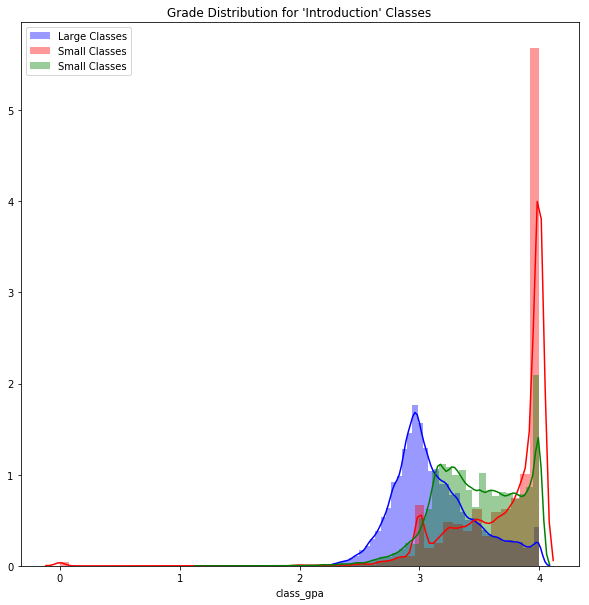

In [59]:
#Plot distribution of GPAs



fig = plt.figure(figsize=(10,10))
plt.title("Grade Distribution for 'Introduction' Classes")
sns.distplot(df_large_class['class_gpa'], color='blue', label="Large Classes")
sns.distplot(df_small_class['class_gpa'], color='red', label="Small Classes")
sns.distplot(df_medium_class['class_gpa'], color='green', label="Small Classes")


#plt.axvline(x=df_large_class['class_gpa'].mean(), color="blue", linestyle="--", linewidth=".5")
#plt.axvline(x=df_small_class['class_gpa'].mean(), color="red", linestyle="--", linewidth=".5")
#plt.axvline(x=critical_t, color="green", linestyle="--", linewidth=".5")

plt.legend()

There are more small classes with very high GPAs (4.0s) but does that mean that smaller classes get higher GPAs on average? The mean GPA is certainly higher for smaller classes.

In [289]:
# What's difference in means
print("Small Class GPA Mean: %s" % df_small_class['class_gpa'].mean())
print("Large Class GPA Mean: %s" % df_large_class['class_gpa'].mean())

Small Class GPA Mean: 3.6396204785657997
Large Class GPA Mean: 3.3091786083746415


Just on means alone, there appears to be a significant difference. .3 grade points is the difference between a B and a B+. But the distributions are very different. 

Large class distribution might be a bit normal, but lumpy.

Small class distribution almost seems exponential.

Since their not both normal, let's sample and apply Central Limit Theorem.

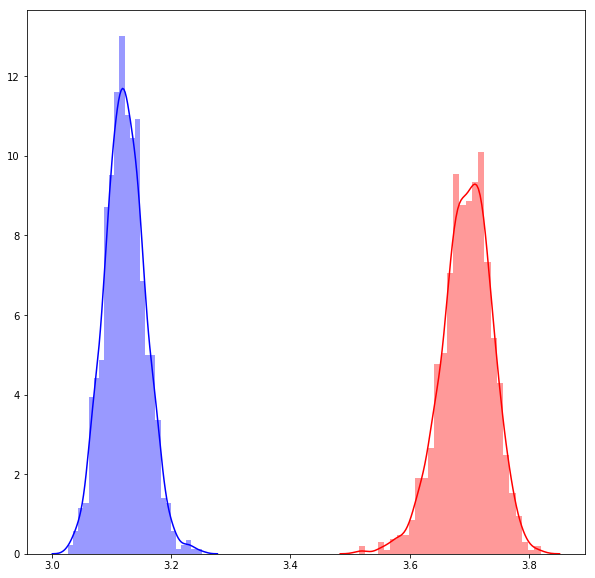

In [70]:
# Smalls are not normally distributed. Using central limit theorem
# to compare the means of samples - small classes vs all classes

fig = plt.figure(figsize=(10,10))

large_samples = []
small_samples = []
for i in range(1000):
    sample1 = df_small_class.sample(100, replace=True)['class_gpa']
    small_samples.append(sample1.mean())
    
    sample2 = df_large_class.sample(100, replace=True)['class_gpa']
    large_samples.append(sample2.mean())

sns.distplot(large_samples, color="blue")
sns.distplot(small_samples, color="red")



In [71]:

print(min(small_samples), max(small_samples))
print(min(large_samples), max(large_samples))

3.5152400793650793 3.8193968253968262
3.027468139114602 3.2513200526573467


In [291]:
# T-test shows small p, but the T- value is crazy. Seems wrong
ttest_ind(small_samples, large_samples, equal_var=False)

Ttest_indResult(statistic=48.92986501890864, pvalue=0.0)

In [292]:
# Manually calculating T instead. 
def t_calc(x, y):
    return (x.mean() - y.mean()) \
/  (len(x) *  np.std(x) + len(y) * np.std(y) \
/  (len(x)  +  len(y)  - 2))

In [293]:
small = np.array(small_samples)
large = np.array(large_samples)

t_val = t_calc(small,large)
t_val

0.002309990778847757

This t-value seems more reasonable

In [311]:
# Get PPF of p-value of alpha =.05 and t-value 
from scipy import stats
d_of_f = 100 - 1

t_critical = stats.norm.ppf(.05)

norm_t = stats.norm.ppf(t_val, loc=df['class_gpa'].mean(), scale=df['class_gpa'].std() )
print(t_critical, norm_t)
print("Is t > t_critical: %s" % (norm_t > t_critical))

-1.6448536269514729 2.4678272467229836
Is t > t_critical: True


# With T larger than our critical T, we can safely reject the null hypothesis on this one. But just to make sure, let's test a few more things

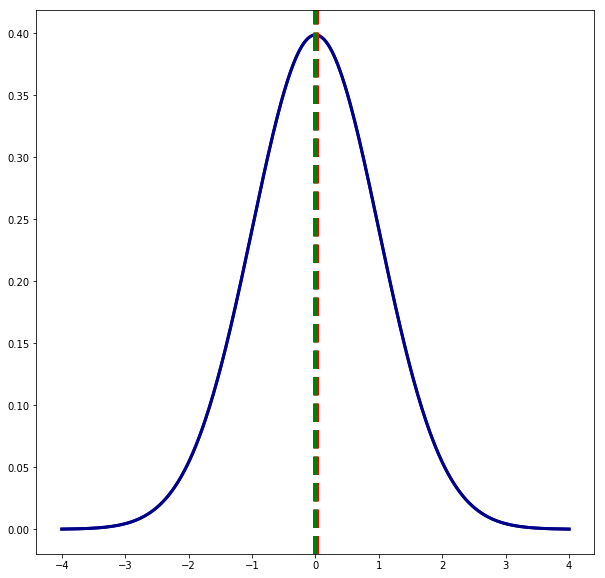

In [299]:
def visualize_t(t_stat, n_control, n_experimental):
    df = (n_control-1)
    xs = np.linspace(-4,4, 500)
    ys = stats.t.pdf(xs, df, 0,1)
    ys2 = stats.t.pdf(xs, n_experimental-1, 0,1)
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca()
    ax.plot(xs,ys, linewidth=3, color='darkblue')
    ax.plot(xs,ys2, linewidth=3, color='darkblue')
    
    ax.axvline(t_stat, color='red', linestyle='--', lw=5,label='t-statistic')
    ax.axvline(-t_stat, color='green', linestyle='--', lw=5,label='Negative t-statistic')
    # initialize a matplotlib "figure"
    # generate points on the x axis between -4 and 4:
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    # Draw two sided boundary for critical-t
    return
n_control = len(large)
n_experimental = len(small)
visualize_t(t_val, n_control, n_experimental)

In [208]:
lower_tail = stats.t.cdf(t_val, len(small))
# Upper tail comulative density function returns area under upper tail curve
upper_tail = 1. - stats.t.cdf(t_val, len(small))

p_value = lower_tail+upper_tail
print(p_value, lower_tail, upper_tail)

1.0 0.5036355687128838 0.49636443128711616


In [136]:
sns.distplot(large_samples, color="blue")
sns.distplot(small_samples, color="red")

3.6575889834228783

In [304]:
# Calculating Cohen D effect size for the two distribution

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / math.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
print(cohen_d(small_samples, large_samples))


2.188210086243375


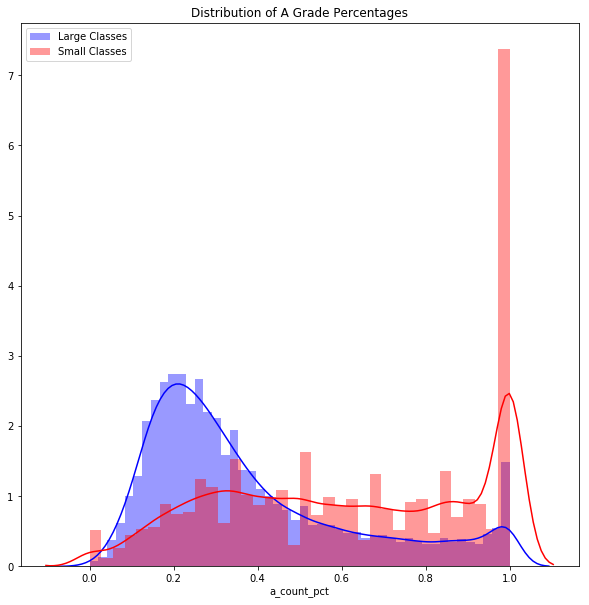

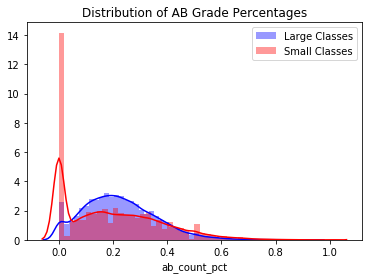

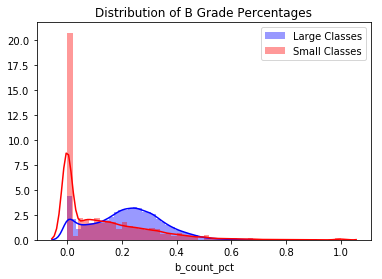

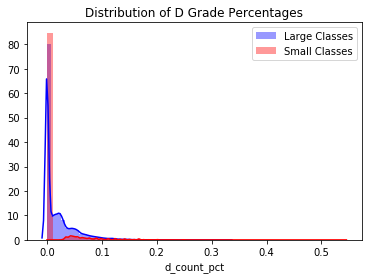

In [318]:
# Let's see if there's something unique going on in each grade handed out As vs. Ds, etc..
# this is just to get more detail about where the discrepancy might be coming from

fig = plt.figure(figsize=(10,10))

sns.distplot(df_large_class["a_count_pct"], color = 'blue', label="Large Classes")
sns.distplot(df_small_class["a_count_pct"], color = 'red', label="Small Classes")
plt.legend()
plt.title("Distribution of A Grade Percentages")
plt.show()

sns.distplot(df_large_class["ab_count_pct"], color = 'blue', label="Large Classes")
sns.distplot(df_small_class["ab_count_pct"], color = 'red', label="Small Classes")
plt.legend()
plt.title("Distribution of AB Grade Percentages")
plt.show()

sns.distplot(df_large_class["b_count_pct"], color = 'blue', label="Large Classes")
sns.distplot(df_small_class["b_count_pct"], color = 'red', label="Small Classes")
plt.legend()
plt.title("Distribution of B Grade Percentages")
plt.show()

sns.distplot(df_large_class["d_count_pct"], color = 'blue', label="Large Classes")
sns.distplot(df_small_class["d_count_pct"], color = 'red', label="Small Classes")
plt.title("Distribution of D Grade Percentages")
plt.legend()
plt.show()





In [209]:
df_large_class["enrollment"].median()



65.0

In [216]:
df_small_class["enrollment"].median()

15.0

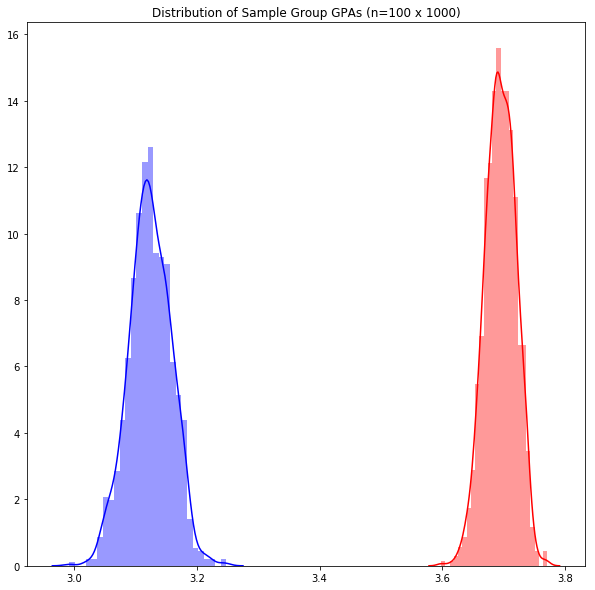

In [69]:

fig = plt.figure(figsize=(10,10))

large_samples2 = []
small_samples2 = []
for i in range(1000):
    sample1 = df_small_class.sample(300, replace=True)
    sample1['sample_gpa'] = sample1['cum_grade']/sample1['enrollment']
        
    small_samples2.append(sample1['sample_gpa'].mean())
    
    sample2 = df_large_class.sample(100, replace=True)
    sample2['sample_gpa'] = sample2['cum_grade']/sample2['enrollment']
    large_samples2.append(sample2['sample_gpa'].mean())

    
plt.title("Distribution of Sample Group GPAs (n=100 x 1000)")
sns.distplot(large_samples2, color="blue")
sns.distplot(small_samples2, color="red")

